**Introduction**
**Objective**: This notebook aims to predict the quality of Vinho Verde wine based on various physicochemical properties. The predictions and model insights will be used to understand key factors affecting wine quality, which will be submitted for evaluation on a Kaggle leaderboard.


**Initial Setup**
Import all necessary libraries and configure the notebook environment for optimal display and performance.

In [ ]:
pip install scikit-optimize


In [2]:
# Setup Cell
# Required imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.preprocessing import StandardScaler


%matplotlib inline

**Loading the Datasets and Data Preprocessing**
Load the training and testing datasets. Perform initial data cleaning and preprocessing steps.


In [3]:
# Load the training and testing datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test_blinded.csv')

# Separate features and target in the training data
train_features = train_data.drop(['quality'], axis=1)
train_labels = train_data['quality']

# Assuming the 'ID' column needs to be excluded from the test features
if 'ID' in test_data.columns:
    test_features = test_data.drop(['ID'], axis=1)
else:
    test_features = test_data

# Scale the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)


Data preprocessing Verification

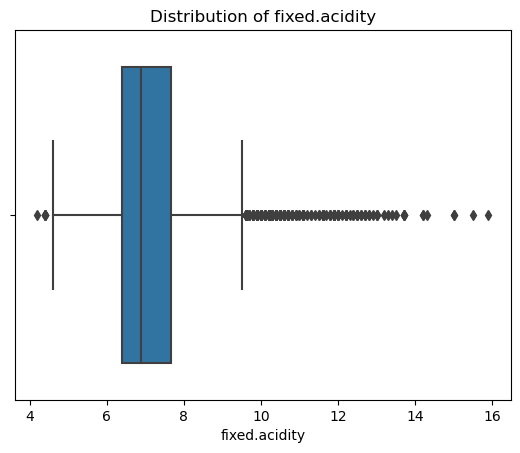

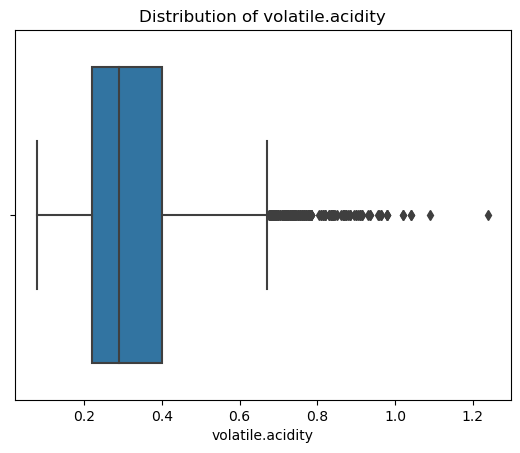

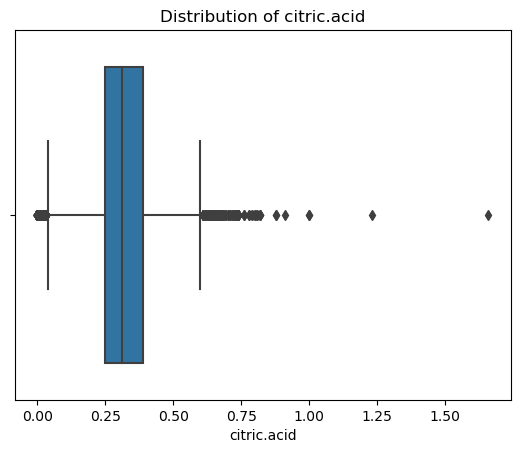

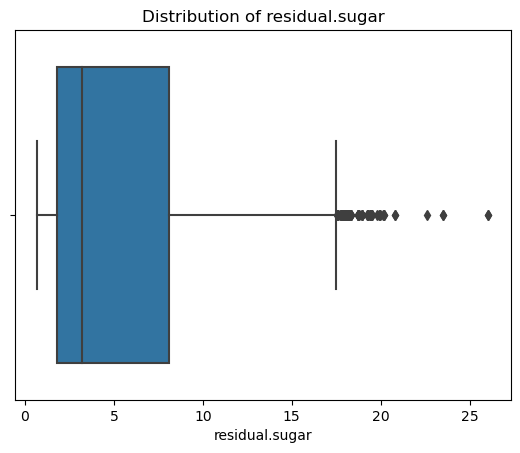

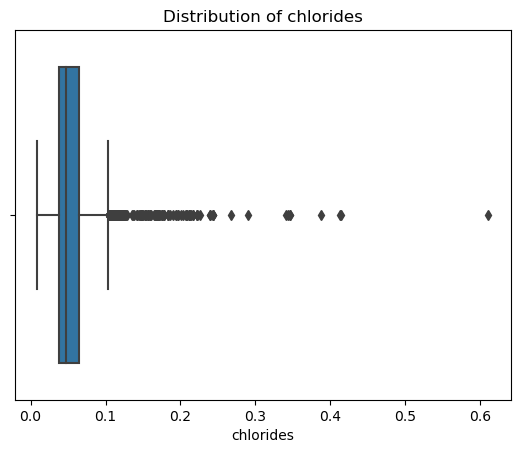

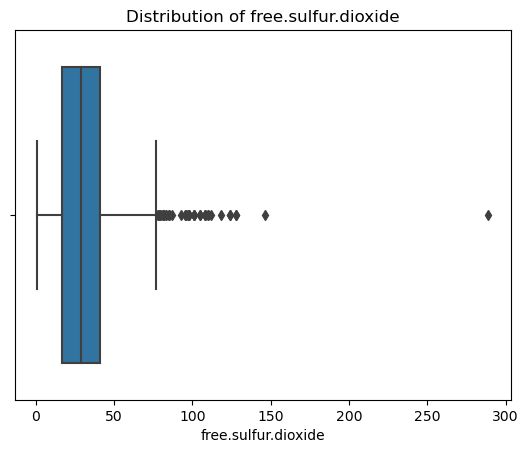

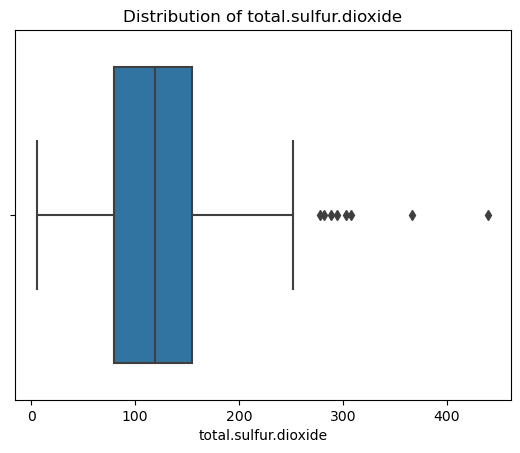

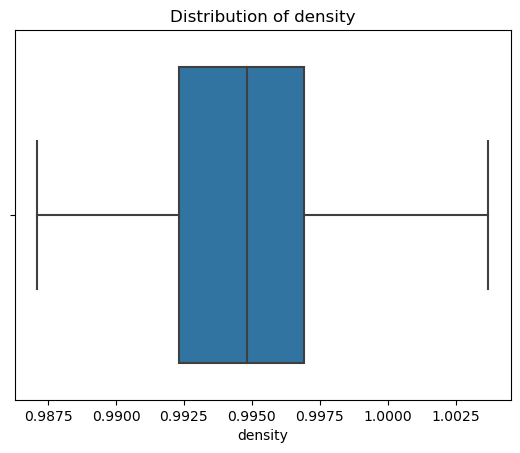

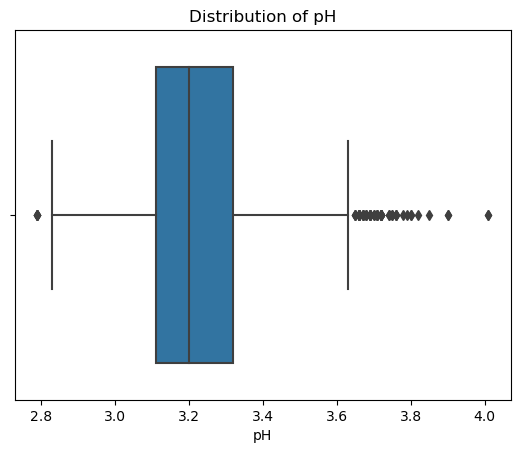

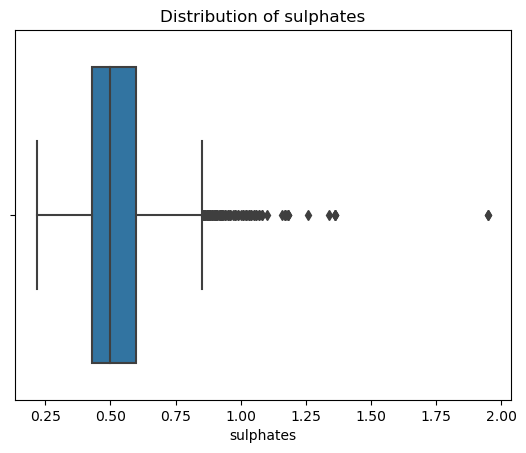

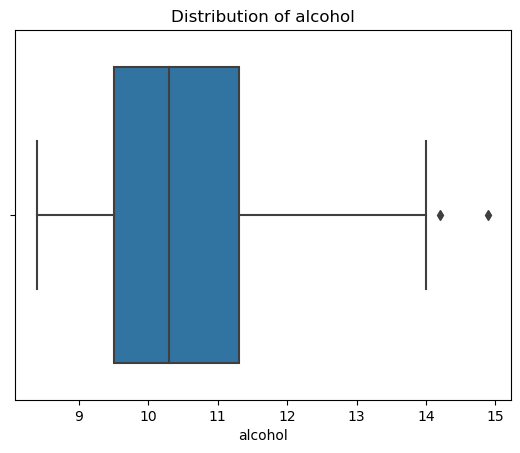

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume train_data has been defined somewhere above this code.
features = ['fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar',
            'chlorides', 'free.sulfur.dioxide', 'total.sulfur.dioxide', 'density',
            'pH', 'sulphates', 'alcohol']

# Plotting distributions for each feature to spot outliers
for feature in features:
    sns.boxplot(x=train_data[feature])
    plt.title(f'Distribution of {feature}')
    plt.show()


## Feature Engineering
Enhance the feature set by adding interaction terms and other engineered features to capture more complex relationships.

In [5]:
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures

# Assuming train_features_scaled and test_features_scaled are already defined
power_transform = PowerTransformer(method='yeo-johnson', standardize=True)
train_features_transformed = power_transform.fit_transform(train_features_scaled)
test_features_transformed = power_transform.transform(test_features_scaled)

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
train_features_poly = poly.fit_transform(train_features_transformed)
test_features_poly = poly.transform(test_features_transformed)


## Model Development and Tuning
Develop and tune a machine learning model using GridSearchCV to find the best parameters. We'll use a GradientBoostingRegressor for this example.


In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import DeltaXStopper

# Split data into training and hold-out test set
X_train, X_test, y_train, y_test = train_test_split(train_features_poly, train_labels, test_size=0.2, random_state=42)

# Define the parameter space for Bayesian optimization
param_space = {
    'n_estimators': Integer(2290, 3390),
    'max_depth': Categorical([None]),
    'min_samples_split': Integer(6, 10),
    'subsample': Real(0.8, 0.9),
    'learning_rate': Real(0.05, 0.07)
}

# Setup Bayesian optimization with early stopping
opt = BayesSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_space,
    n_iter=15,  # Reduced to 15 iterations
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    return_train_score=False,
    random_state=42
)

# Callback for early stopping based on the test score
callback = DeltaXStopper(delta=0.01)

try:
    # Perform the search on the training subset
    opt.fit(X_train, y_train, callback=callback)
    
    # Extract the best model and evaluate it on the hold-out test set
    best_model = opt.best_estimator_
    predictions = best_model.predict(X_test)
    test_mse = mean_squared_error(y_test, predictions)
    
    # Display the best parameters
    best_params = opt.best_params_
    print("Best parameters:", best_params)
    
    print("Test MSE:", test_mse)
    if test_mse <= 0.10:
        print("Target MSE of 0.10 reached on test set.")
    else:
        print("Target MSE of 0.10 not reached on test set; may need further tuning.")
except KeyboardInterrupt:
    print("Optimization was interrupted manually.")


Best parameters: OrderedDict([('learning_rate', 0.060868061353806256), ('max_depth', None), ('min_samples_split', 8), ('n_estimators', 3211), ('subsample', 0.8324059982284374)])
Test MSE: 0.2662699336828711
Target MSE of 0.10 not reached on test set; may need further tuning.


## Train & Evaluate the Final Model
Train the GradientBoostingRegressor using the best parameters found from the GridSearchCV.


In [ ]:
# Training the model with the best parameters
final_model = GradientBoostingRegressor(
    n_estimators=bayes_search.best_params_['n_estimators'],
    max_depth=bayes_search.best_params_['max_depth'],
    learning_rate=bayes_search.best_params_['learning_rate'],
    random_state=42
)
final_model.fit(train_features_poly, train_labels)

# Cross-validate the model
cv_scores = cross_val_score(final_model, train_features_poly, train_labels, cv=5, scoring='neg_mean_squared_error')
mean_cv_score = -cv_scores.mean()
print(f"Cross-validated Mean MSE: {mean_cv_score}")


## Model Evaluation
Evaluate the model using cross-validation to ensure it generalizes well across unseen data.


In [ ]:
from sklearn.model_selection import cross_val_score

# Assuming `best_model` has already been defined as your best model from earlier optimization.
cv_scores = cross_val_score(best_model, train_features_poly, train_labels, cv=5, scoring='neg_mean_squared_error')
mean_cv_score = -cv_scores.mean()
print(f"Cross-validated Mean MSE: {mean_cv_score}")


## Generate Predictions and Prepare Submission
Generate predictions on the test set using the best model and prepare the submission file according to Kaggle's format.


**Model Training**
Training a RandomForestRegressor with hyperparameter tuning using GridSearchCV.

In [ ]:
# Generate predictions on the processed test features
test_predictions = best_model.predict(test_features_poly)

# Assuming `test_data` has an 'ID' column that identifies each sample
submission_df = pd.DataFrame({
    'ID': test_data['ID'],  # Make sure the ID column is correctly referenced
    'predicted_quality': test_predictions
})


## Prepare submission file
Re-evaluating the model's performance using cross-validation to ensure robustness.


In [ ]:
submission_df.to_csv('submission.csv', index=False)
print("Submission file created:")
print(submission_df.head())
